Используя базу "Аудиожанры", примените подход к музыке как к тексту и напишите сверточный классификатор (на базе слоя Conv1D) для подготовленных данных. Для этого:

1. Измените подготовку данных так, чтобы набор признаков, извлекаемый из аудиофайла, был представлен в виде последовательностей векторов признаков. Последовательности должны быть фиксированного размера и выбираться скользящим окном c заданным шагом. Другими словами: берем аудио-файл длительность, например, 30 сек. Берем отрезок фиксированной длины (например, 5с) и получаем набор признаков для этого отрезка. Смещаемся на шаг (например, 1с) и берем следующий отрезок. Таким образом готовим обучающую вборку.
2. Длину последовательности, размер шага и достаточный набор признаков определите самостоятельно исходя из требований к точности классификатора;
3. Разработайте классификатор на одномерных сверточных слоях **Conv1D** с точностью классификации жанра на тестовых данных не ниже **60%**, а на обучающих файлах - **68%** и выше;
4. Используйте за основу материал с урока, но при желании разработайте свои инструменты.

Импортируем необходимые библиотеки:

In [ ]:
# Массивы
import numpy as np

# Отрисовка графиков
import matplotlib.pyplot as plt

# Загрузка из google облака
import gdown

# Преобразование категориальных данных в one hot encoding
from tensorflow.keras.utils import to_categorical

# Работа с папками и файлами
import os

# Утилиты работы со временем
import time

# Работа со случайными числами
import random

# Математические функции
import math

# Сохранение и загрузка структур данных Python
import pickle

# Параметризация аудио
import librosa

# Оптимизаторы для обучения моделей
from tensorflow.keras.optimizers import Adam, RMSprop

# Конструирование и загрузка моделей нейронных сетей
from tensorflow.keras.models import Sequential, Model, load_model

# Основные слои
from tensorflow.keras.layers import concatenate, Input, Dense, Dropout, BatchNormalization, Flatten, Conv1D, Conv2D, LSTM
from tensorflow.keras.layers import MaxPooling1D, AveragePooling1D, SpatialDropout1D

# Разбиение на обучающую и проверочную выборку
from sklearn.model_selection import train_test_split

# Кодирование категориальных меток, нормирование числовых данных
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Матрица ошибок классификатора
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Отключение предупреждений
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline 

Загрузим датасет в Colab:

In [ ]:
# Загрузка датасета из облака
gdown.download('https://storage.yandexcloud.net/aiueducation/Content/base/l12/genres.zip', None, quiet=True)

'genres.zip'

In [ ]:
# Распаковка архива на локальный диск colab
!unzip -qo genres.zip

# Проверка выгруженных папок
!ls genres 

# Проверка содержимого одной папки
!ls genres/blues

blues  classical  country  disco  hiphop  jazz	metal  pop  reggae  rock
blues.00000.au	blues.00020.au	blues.00040.au	blues.00060.au	blues.00080.au
blues.00001.au	blues.00021.au	blues.00041.au	blues.00061.au	blues.00081.au
blues.00002.au	blues.00022.au	blues.00042.au	blues.00062.au	blues.00082.au
blues.00003.au	blues.00023.au	blues.00043.au	blues.00063.au	blues.00083.au
blues.00004.au	blues.00024.au	blues.00044.au	blues.00064.au	blues.00084.au
blues.00005.au	blues.00025.au	blues.00045.au	blues.00065.au	blues.00085.au
blues.00006.au	blues.00026.au	blues.00046.au	blues.00066.au	blues.00086.au
blues.00007.au	blues.00027.au	blues.00047.au	blues.00067.au	blues.00087.au
blues.00008.au	blues.00028.au	blues.00048.au	blues.00068.au	blues.00088.au
blues.00009.au	blues.00029.au	blues.00049.au	blues.00069.au	blues.00089.au
blues.00010.au	blues.00030.au	blues.00050.au	blues.00070.au	blues.00090.au
blues.00011.au	blues.00031.au	blues.00051.au	blues.00071.au	blues.00091.au
blues.00012.au	blues.00032.a

In [ ]:
# Ваше решение

In [ ]:
# Установка констант

FILE_DIR = './genres'                     # Папка с файлами датасета
CLASS_LIST = os.listdir(FILE_DIR)         # Список классов, порядок меток не определен!
CLASS_LIST.sort()                         # Сортировка списка классов для фиксации порядка меток
CLASS_COUNT = len(CLASS_LIST)             # Количество классов
CLASS_FILES = 100                         # Общее количество файлов в каждом классе
FILE_INDEX_TRAIN_SPLIT = 90               # Количество файлов каждого класса на основной набор
VALIDATION_SPLIT = 0.1                    # Доля проверочной выборки в основном наборе
DURATION_SEC = 30                         # Анализируемая длительность аудиосигнала
N_FFT = 8192                              # Размер окна преобразования Фурье для расчета спектра
HOP_LENGTH = 512                          # Объем данных для расчета одного набора признаков, получается 1300 векторов аудио в одном аудиофайле 30 сек

SEQ_LENGTH = 150                          # Размер последовательности при нарезки
SEQ_HOP_LENGTH = 20                       # Размер шага нарезки последовательностей



In [ ]:
# Проверка списка классов
print(CLASS_LIST)

['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']


In [ ]:
# Функция параметризации аудио

def get_features(y,                     # волновое представление сигнала
                 sr,                    # частота дискретизации сигнала y
                 n_fft=N_FFT,           # размер скользящего окна БПФ
                 hop_length=HOP_LENGTH  # шаг скользящего окна БПФ
                 ):
    # Вычисление различных параметров (признаков) аудио

    # Хромаграмма 12 признаков - это 12 нот
    chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length)
    # 1Мел-кепстральные коэффициенты 20 по умолчанию
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length)
    # 2Среднеквадратическая амплитуда по 1 значению для других признаков
    rmse = librosa.feature.rms(y=y, hop_length=hop_length)
    # 3Спектральный центроид по 1 значению для других признаков
    spec_cent = librosa.feature.spectral_centroid(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length)
    # 4Ширина полосы частот по 1 значению для других признаков
    spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length)
    # 5Спектральный спад частоты по 1 значению для других признаков
    rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length)
    # 6Пересечения нуля
    zcr = librosa.feature.zero_crossing_rate(y, hop_length=hop_length)
    
    # Сборка параметров в общий список и усреднение по всей песни:
    # На один файл один усредненный вектор признаков
    features = {'rmse': rmse.mean(axis=1, keepdims=True),
                'spct': spec_cent.mean(axis=1, keepdims=True),
                'spbw': spec_bw.mean(axis=1, keepdims=True),
                'roff': rolloff.mean(axis=1, keepdims=True),
                'zcr' : zcr.mean(axis=1, keepdims=True),
                'mfcc': mfcc.mean(axis=1, keepdims=True),
                'stft': chroma_stft.mean(axis=1, keepdims=True)}

    return features

In [ ]:
# Функция объединения признаков в набор векторов

def stack_features(feat  # словарь признаков, отдельные векторы по ключу каждого признака
                   ):
    features = None
    for v in feat.values():
        features = np.vstack((features, v)) if features is not None else v

    return features.T

Волна (661500,)
Частота дискретизации 22050
Длительность сигнала 30.0 секунд 



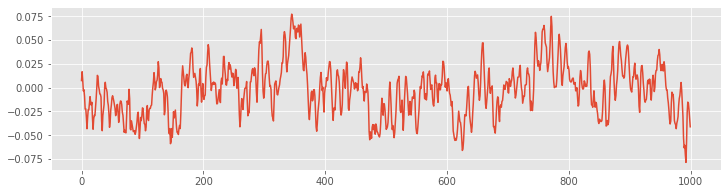

In [ ]:
# проверка параметризации одного произведения
y, sr = librosa.load(f'{FILE_DIR}/blues/blues.00000.au', mono = True, duration = DURATION_SEC)

print('Волна', y.shape)
print('Частота дискретизации', sr)
print('Длительность сигнала', y.shape[0]/sr, 'секунд \n')

plt.style.use('ggplot')
plt.figure(figsize = (12, 3))
plt.plot(y[:1000]) #первые 1000 значений амплитуды сигналов
plt.show()


In [ ]:
# Извлечение параметров из аудиосигнала
features = get_features(y, sr)
print({k: v.shape for k, v in features.items()})



{'rmse': (1, 1), 'spct': (1, 1), 'spbw': (1, 1), 'roff': (1, 1), 'zcr': (1, 1), 'mfcc': (20, 1), 'stft': (12, 1)}


In [ ]:
# транспонирует строки столбцами а столбцы строками
feature_set = stack_features(features)
feature_set.shape

(1, 37)

In [ ]:
feature_set[0]

array([ 1.30224630e-01,  1.81538390e+03,  2.02407957e+03,  3.86143498e+03,
        8.30663911e-02,  4.45649567e+01,  1.28035797e+02, -2.23348103e+01,
        4.18042336e+01, -9.72531986e+00,  1.98680515e+01, -1.74135780e+01,
        1.76154556e+01, -1.46662998e+01,  1.27859850e+01, -1.06820002e+01,
        1.18023500e+01, -5.16585684e+00,  7.78427172e+00, -7.35019302e+00,
        2.49901366e+00, -3.37611985e+00,  1.30031204e+00, -3.79941535e+00,
        2.28564262e+00,  3.78360391e-01,  3.61972690e-01,  4.67484891e-01,
        2.39600882e-01,  2.46317670e-01,  3.56771946e-01,  3.71764511e-01,
        4.89738643e-01,  2.85779864e-01,  3.10171574e-01,  4.18150812e-01,
        3.84085506e-01])

In [ ]:
# Функция формирования набора признаков и метки класса для аудиофайла

def get_feature_list_from_file(class_index,  # индекс класса файла song_name
                               song_name,    # имя аудиофайла
                               duration_sec  # длительность аудио в секундах
                               ):
    # Загрузка в y первых duration_sec секунд аудиосигнала
    y, sr = librosa.load(song_name, mono=True, duration=duration_sec)

    # Извлечение параметров из аудиосигнала
    features = get_features(y, sr)
    feature_set = stack_features(features)

    # Перевод номера класса в one hot encoding
    y_label = to_categorical(class_index, CLASS_COUNT)

    return feature_set, y_label

In [ ]:
# Функция формирования подвыборки признаков и меток класса для одного файла

def process_file(class_index,  # индекс класса аудиофайла
                 file_index,   # индекс (порядковый номер) аудиофайла в папке класса
                 duration_sec  # длительность аудио в секундах
                 ):
    x_list = []
    y_list = []
    class_name = CLASS_LIST[class_index]

    # Извлечение имени произведения
    song_name = f'{FILE_DIR}/{class_name}/{class_name}.{str(file_index).zfill(5)}.au'

    # Выборка признаков и метки класса для произведения
    feature_set, y_label = get_feature_list_from_file(class_index, 
                                                        song_name,
                                                        duration_sec)

    # Добавление данных в наборы нарезка набора признаков файла на последовательности
    feature_len = feature_set.shape[0]
    x_list = [feature_set[i:i+SEQ_LENGTH] for i in range(0, feature_len - SEQ_LENGTH + 1, SEQ_HOP_LENGTH)]

    # Добавление верных меток класса по числу последовательностей
    y_list = [y_label] * len(x_list)


    for j in range(feature_set.shape[0]):
        x_list.append(feature_set[j])
        y_list.append(y_label)

    # Возврат имени файла и numpy-массивов призанков и меток класса
    return song_name, \
           np.array(x_list).astype('float32'), \
           np.array(y_list).astype('float32')

In [ ]:
# Функция формирования набора данных из файлов всех классов по диапазону номеров файлов

def extract_data(file_index_start,          # начальный индекс аудиофайла
                 file_index_end,            # конечный индекс аудиофайла (не достигая)
                 duration_sec=DURATION_SEC  # длительность аудио в секундах
                 ):

    # Списки для последовательностей входных данных и меток класса
    x_data = None
    y_data = None

    # Фиксация времени старта формирования выборки
    curr_time = time.time()

    # Для всех классов:
    for class_index in range(len(CLASS_LIST)):
        # Для всех файлов текущего класса из заданного диапазона номеров:
        for file_index in range(file_index_start, file_index_end):
            # Обработка одного файла и добавление данных к общим массивам
            _, file_x_data, file_y_data = process_file(class_index, file_index, duration_sec)
            x_data = file_x_data if x_data is None else np.vstack([x_data, file_x_data])
            y_data = file_y_data if y_data is None else np.vstack([y_data, file_y_data])

        # Вывод информации о готовности обработки датасета
        print(f'Жанр {CLASS_LIST[class_index]} готов -> {round(time.time() - curr_time)} c')
        curr_time = time.time()

    # Возврат массивов набора данных
    return x_data, y_data

In [ ]:
# формирование тренировочного набора данных

x_train_data, y_train_data = extract_data(0, FILE_INDEX_TRAIN_SPLIT)

Жанр blues готов -> 120 c
Жанр classical готов -> 118 c
Жанр country готов -> 118 c
Жанр disco готов -> 115 c
Жанр hiphop готов -> 124 c
Жанр jazz готов -> 118 c
Жанр metal готов -> 115 c
Жанр pop готов -> 115 c
Жанр reggae готов -> 115 c
Жанр rock готов -> 114 c


In [ ]:
# загрузка подготовленных данных
gdown.download('https://storage.yandexcloud.net/aiueducation/Content/base/l12/audio_data_seq100.pickle', None, quiet=True)

'audio_data_seq100.pickle'

In [ ]:
# Восстановление датасета аудио
# Данные привязаны к порядку следования меток классов!
# Порядок классов фиксирован сортировкой списка меток классов

with open('audio_data_seq100.pickle', 'rb') as f:
    x_train_data, y_train_data = pickle.load(f)

In [ ]:
print(x_train_data.shape, y_train_data.shape)

(54000, 100, 25) (54000, 10)


In [ ]:
# формирование тестовой выборки из файлов не вошедших в основной набор

x_test, y_test = extract_data(FILE_INDEX_TRAIN_SPLIT, CLASS_FILES)

Жанр blues готов -> 12 c
Жанр classical готов -> 12 c
Жанр country готов -> 13 c
Жанр disco готов -> 12 c
Жанр hiphop готов -> 14 c
Жанр jazz готов -> 13 c
Жанр metal готов -> 13 c
Жанр pop готов -> 12 c
Жанр reggae готов -> 12 c
Жанр rock готов -> 13 c


In [ ]:
# Восстановление датасета аудио
# Данные привязаны к порядку следования меток классов!
# Порядок классов фиксирован сортировкой списка меток классов

with open('audio_data_seq100.pickle', 'rb') as f:
    x_test_data, y_test_data = pickle.load(f)

In [ ]:
x_train = x_train_data
y_train = y_train_data

In [ ]:
x_test = x_test_data
y_test = y_test_data

In [ ]:
print(x_train.shape, x_train.dtype)
print(y_train.shape, y_train.dtype)
print()
print(x_test.shape, x_test.dtype)
print(y_test.shape, y_test.dtype)

(54000, 100, 25) float32
(54000, 10) float32

(54000, 100, 25) float32
(54000, 10) float32


In [ ]:
print(x_test_data.shape, y_test_data.shape)

(54000, 100, 25) (54000, 10)


In [ ]:
# Вывод графиков точности и ошибки распознавания на обучающей и проверочной выборках

def show_history(history  # объект-результат метода обучения .fit()
                 ):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))
    fig.suptitle('График процесса обучения модели')
    ax1.plot(history.history['accuracy'], 
               label='Доля верных ответов на обучающем наборе')
    ax1.plot(history.history['val_accuracy'], 
               label='Доля верных ответов на проверочном наборе')
    ax1.xaxis.get_major_locator().set_params(integer=True)
    ax1.set_xlabel('Эпоха обучения')
    ax1.set_ylabel('Доля верных ответов')
    ax1.legend()

    ax2.plot(history.history['loss'], 
               label='Ошибка на обучающем наборе')
    ax2.plot(history.history['val_loss'], 
               label='Ошибка на проверочном наборе')
    ax2.xaxis.get_major_locator().set_params(integer=True)
    ax2.set_xlabel('Эпоха обучения')
    ax2.set_ylabel('Ошибка')
    ax2.legend()
    plt.show()

In [ ]:
# Функция оценки точности модели на заданной выборке

def eval_model(model,  # обученная модель нейронной сети
               x,      # входные данные
               y_true  # выходные данные (верные ответы)
               ):
    loss, acc = model.evaluate(x, y_true)
    print(f'Ошибка: {loss}, точность: {acc}')

    # Построение матрицы ошибок
    y_pred = model.predict(x)
    cm = confusion_matrix(np.argmax(y_true, axis=1),
                          np.argmax(y_pred, axis=1),
                          normalize='true')

    # Отрисовка матрицы ошибок
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.set_title('Матрица ошибок нормализованная')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=CLASS_LIST)
    disp.plot(ax=ax)
    plt.show()    

In [ ]:
# Классификация файла и визуализация предсказания модели для него

def classify_file(model,        # обученная модель классификатора
                  class_index,  # верный индекс класса аудиофайла
                  file_index    # индекс (порядковый номер) аудиофайла в папке
                  ):
    # Подготовка выборки данных файла произведения
    song_name, file_x_data, file_y_data = process_file(class_index, file_index, DURATION_SEC)
 

    print('Файл:', song_name)
    print('Векторы для предсказания:', file_x_data.shape)

    # Вычисление предсказания по выборке
    predict = model.predict(file_x_data)
    # Определение среднего предсказания (голосование)
    predict_mean = predict.mean(axis=0)
    # Определение индекса класса по результату голосования
    predict_class_index = np.argmax(predict_mean)
    # Вычисление признака правильного предсказания
    predict_good = predict_class_index == class_index

    # Визуализация предсказания сети для файла
    plt.figure(figsize=(10,3))
    print('Классификация сети:', CLASS_LIST[predict_class_index], '-', 'ВЕРНО :-)' if predict_good else 'НЕВЕРНО.')
    plt.title('Среднее распределение векторов предсказаний')
    plt.bar(CLASS_LIST, predict_mean, color='g' if predict_good else 'r')
    plt.show()
    print('---------------------------------------------------------------')

    # Возврат результата предсказания
    return predict_class_index

In [ ]:
# Классификация и визуализация нескольких файлов каждого класса 

def classify_test_files(model,       # обученная модель классификатора
                        from_index,  # индекс аудиофайла, с которого начинать визуализацию
                        n_files):    # количество файлов для визуализации
    predict_all = 0
    predict_good = 0
    y_true = []
    y_pred = []
    for class_index in range(CLASS_COUNT):
        for file_index in range(from_index, from_index + n_files):
            predict_class_index = classify_file(model, class_index, file_index)
            y_true.append(class_index)
            y_pred.append(predict_class_index)
            predict_all += 1
            predict_good += (predict_class_index == class_index)

    # Расчет и вывод итогов классификации
    good_ratio = round(predict_good / predict_all * 100., 2)
    print(f'=== Обработано образцов: {predict_all}, из них распознано верно: {predict_good}, доля верных: {good_ratio}% ===')   

    # Построение матрицы ошибок без нормализации, покажет попадания в штуках
    cm = confusion_matrix(y_true, y_pred)

    # Отрисовка матрицы ошибок
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.set_title('Матрица ошибок по файлам аудио (не нормализованная)')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=CLASS_LIST)
    disp.plot(ax=ax)
    plt.show()

In [ ]:
def create_model():
    # Последовательная модель нейронной сети
    model = Sequential()
    
    # Входной слой
    model.add(Input(shape=x_train.shape[1:]))

    # Первый сверточный блок
    model.add(BatchNormalization())
    model.add(Conv1D(256, (3,), activation='relu'))
    model.add(MaxPooling1D(2))
    

    # Второй сверточный блок
    model.add(BatchNormalization())
    model.add(Conv1D(256, (3,), activation='relu'))
    model.add(MaxPooling1D(3))
   

    # Третий сверточный блок
    model.add(BatchNormalization())
    model.add(Conv1D(256, (2,), activation='relu'))
    model.add(MaxPooling1D(2))
    

    # Полносвязный блок
    model.add(Flatten())
    model.add(BatchNormalization())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.6))

    # Финальный слой классификации
    model.add(Dense(CLASS_COUNT, activation='softmax'))

    return model

In [ ]:
# Используем для работы с категориальными данными
from tensorflow.keras import utils 

In [ ]:
model = create_model()

In [ ]:

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_13 (Bat  (None, 100, 25)          100       
 chNormalization)                                                
                                                                 
 conv1d_12 (Conv1D)          (None, 98, 256)           19456     
                                                                 
 max_pooling1d_12 (MaxPoolin  (None, 49, 256)          0         
 g1D)                                                            
                                                                 
 batch_normalization_14 (Bat  (None, 49, 256)          1024      
 chNormalization)                                                
                                                                 
 conv1d_13 (Conv1D)          (None, 47, 256)           196864    
                                                      

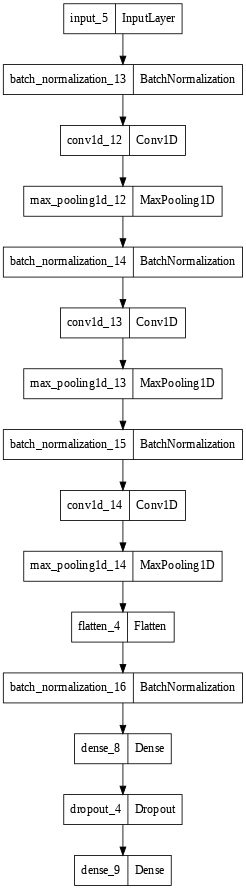

In [ ]:
utils.plot_model(model, dpi=60)

In [ ]:
# 'sparse_categorical_crossentropy' потому что подаём числа больше единицы

model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics='accuracy')



Epoch 1/50
1460/1460 [==============================] - 19s 12ms/step - loss: 1.3208 - accuracy: 0.5755 - val_loss: 0.4993 - val_accuracy: 0.8294
Epoch 2/50
1460/1460 [==============================] - 15s 10ms/step - loss: 0.6916 - accuracy: 0.7634 - val_loss: 0.2601 - val_accuracy: 0.9159
Epoch 3/50
1460/1460 [==============================] - 14s 10ms/step - loss: 0.4700 - accuracy: 0.8371 - val_loss: 0.1659 - val_accuracy: 0.9479
Epoch 4/50
1460/1460 [==============================] - 15s 10ms/step - loss: 0.3377 - accuracy: 0.8832 - val_loss: 0.1158 - val_accuracy: 0.9637
Epoch 5/50
1460/1460 [==============================] - 15s 10ms/step - loss: 0.2658 - accuracy: 0.9068 - val_loss: 0.0766 - val_accuracy: 0.9763
Epoch 6/50
1460/1460 [==============================] - 15s 10ms/step - loss: 0.2143 - accuracy: 0.9246 - val_loss: 0.0558 - val_accuracy: 0.9839
Epoch 7/50
1460/1460 [==============================] - 14s 10ms/step - loss: 0.1744 - accuracy: 0.9387 - val_loss: 0.0420 -

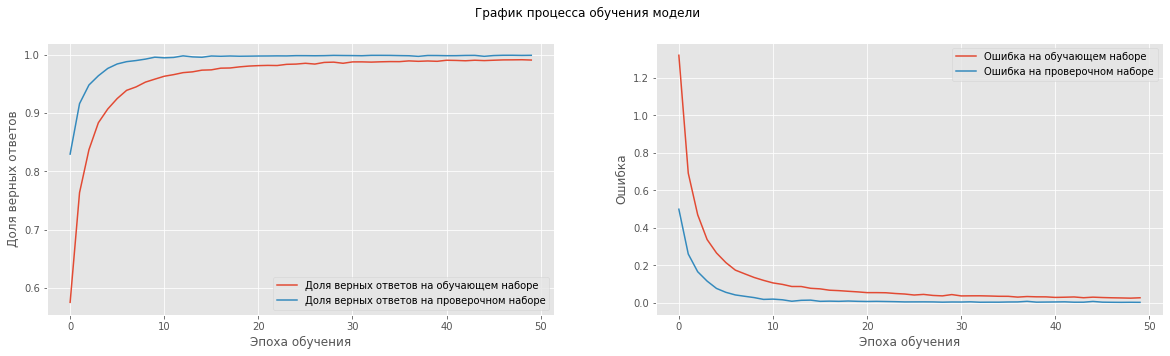

In [ ]:
history = model.fit(x_train,
                    y_train,
                    epochs=50,
                    batch_size=37,
                    validation_data=(x_test, y_test),
                    verbose = 1)
                   

show_history(history)

1688/1688 [==============================] - 7s 4ms/step - loss: 0.0025 - accuracy: 0.9987
Ошибка: 0.0024519404396414757, точность: 0.9987407326698303
1688/1688 [==============================] - 4s 2ms/step


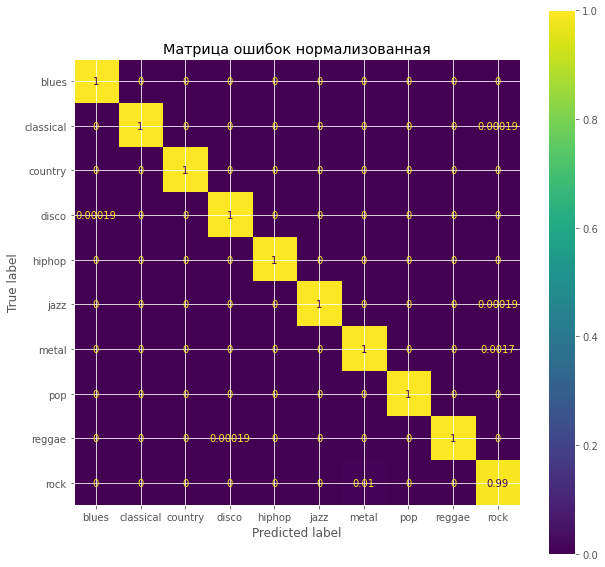

In [ ]:
# Оценка точности сети на проверочной выборке
eval_model(model, x_test, y_test)